In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from iactrace import (
    Telescope, MCIntegrator, hexshow, squareshow
)

# Import HESS I telescope configuration:

In [4]:
%%time
integrator = MCIntegrator(64)
telescope = Telescope.from_yaml('../configs/HESS/CT1.yaml', integrator, key = jax.random.key(42))

CPU times: user 4.17 s, sys: 481 ms, total: 4.65 s
Wall time: 5.67 s


Apply mirror roughness (in arcseconds) due to imperfect surface:

In [5]:
telescope = telescope.apply_roughness(28, jax.random.key(43))

# Simulating a star field:

In [6]:
# Generate star field
n_stars = 10000
key = jax.random.key(42)
key1, key2 = jax.random.split(key)

# Small angular region (6 degrees field of view)
fov_deg = 6
fov_rad = fov_deg * jnp.pi / 180

x = jax.random.uniform(key1, (n_stars,), minval=-fov_rad/2, maxval=fov_rad/2)
y = jax.random.uniform(key2, (n_stars,), minval=-fov_rad/2, maxval=fov_rad/2)
z = -jnp.ones(n_stars)

stars = jnp.stack([x, y, z], axis=1)
stars = stars / jnp.linalg.norm(stars, axis=1, keepdims=True)

# Set random flux values for stars:
key = jax.random.key(4242)
f_stars = 10**(-10*jax.random.uniform(key, shape=(len(stars),)))

In [7]:
%%time
image_science = telescope(stars, f_stars, source_type='infinity', sensor_idx=0).block_until_ready()
image_lid = telescope(stars, f_stars, source_type='infinity', sensor_idx=1).block_until_ready()

CPU times: user 2.01 s, sys: 229 ms, total: 2.24 s
Wall time: 2.92 s


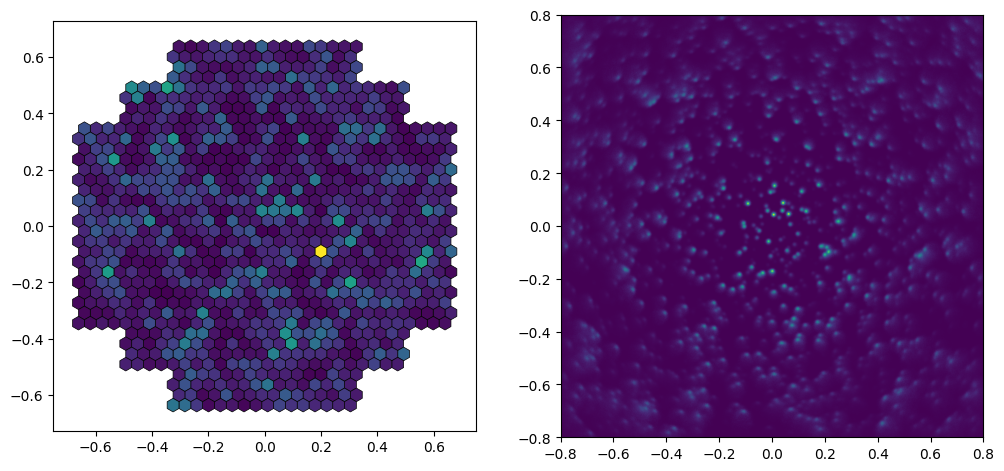

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax_hex = hexshow(image_science, telescope.sensors[0], ax=ax[0])
ax_square = squareshow(image_lid, telescope.sensors[1], ax=ax[1])

# Simulating a point source at finite distance:

In [9]:
N_points = 1

key = jax.random.key(12)
key1, key2 = jax.random.split(key)

x = jax.random.uniform(key1, N_points, minval=-0.0001, maxval=0.0001)
y = jax.random.uniform(key2, N_points, minval=-0.0001, maxval=0.0001)
z = jnp.ones(N_points) * 250

points = jnp.array([x,y,z]).T
f_points = np.ones(len(points))

In [10]:
%%time
image_science = telescope(points, f_points, source_type='point', sensor_idx=0).block_until_ready()
image_lid = telescope(points, f_points, source_type='point', sensor_idx=1).block_until_ready()

CPU times: user 1.83 s, sys: 109 ms, total: 1.94 s
Wall time: 1.94 s


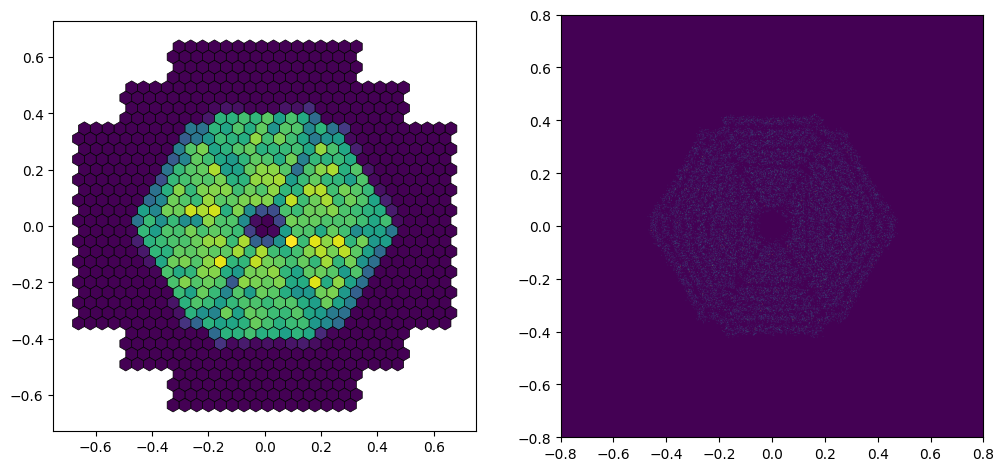

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax_hex = hexshow(image_science, telescope.sensors[0], ax=ax[0])
ax_square = squareshow(image_lid, telescope.sensors[1], ax=ax[1])